In [1]:
%matplotlib inline
import pandas as pd
import nupis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gp
import pysal as ps
import pysal.contrib.viz.mapping as maps
import palettable

pd.options.mode.chained_assignment = None

sns.set(style='whitegrid', palette='bright', context='notebook')

### Notebook para realizar a análise espacial de uma variável para os setores censitários de um município (como Varginha) e para os municípios do estado (MG, por exemplo)

Este notebook é útil para quem for:

- usar algum dos conjuntos de dados do IBGE (como 'Domicilio01_MG.csv') que contém informações divididas por setor censitário e não está agrupado por município
- comparar os resultados da AEDE de uma variável nos setores censitários de Varginha com a AEDE da mesma variável nos municípios de MG

Análises:
- AEDE do número absoluto de domicílios particulares permanentes do tipo apartamento próprios e quitados de Varginha
- AEDE da porcentagem de apartamentos quitados de Varginha (V178 / V005)
- AEDE do número absoluto de domicílios particulares permanentes do tipo apartamento próprios e quitados de MG
- AEDE da porcentagem de apartamentos de Varginha (V005 / V002)
- AEDE da porcentagem de apartamentos quitados para os municípios de MG (V178 / V005)

Algumas variáveis de 'Domicilio01_MG.csv':
- V001 Domicílios particulares e domicílios coletivos
- V002 Domicílios particulares permanentes
- V003 Domicílios particulares permanentes do tipo casa
- V004 Domicílios particulares permanentes do tipo casa de vila ou em condomínio
- V005 Domicílios particulares permanentes do tipo apartamento
- V006 Domicílios particulares permanentes próprios e quitados
- V007 Domicílios particulares permanentes próprios em aquisição
- V008 Domicílios particulares permanentes alugados
- V178: Domicílios particulares permanentes do tipo apartamento próprios e quitados

In [2]:
# estado de Minas Gerais dividido em setores censitários
setores = gp.read_file('dados/31SEE250GC_SIR.shp') 

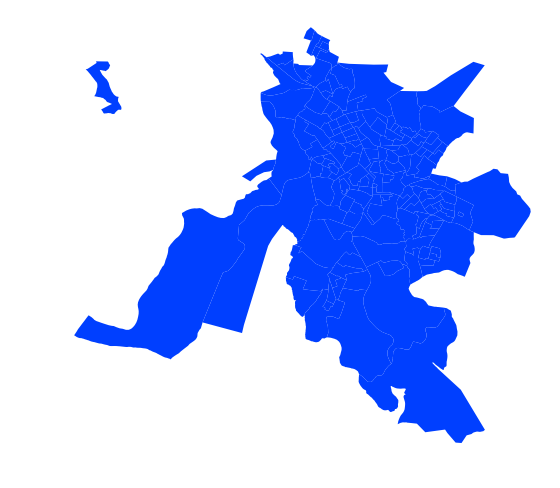

In [3]:
# a partir do shapefile de setores de MG, selecionar o município de Varginha e apenas os setores urbanos
vga = setores.query('NM_MUNICIP == "VARGINHA"')
mapa_vga = vga.query('TIPO == "URBANO"')
mapa_vga.plot(figsize=(9,9)).set_axis_off();

### Agora vamos pegar variáveis sobre os setores censitários de MG e utilizar os de Varginha.

Escolher alguma planilha de dados com informações sobre setores censitários. Havíamos utilizado 'basico_MG.csv', agora podemos escolher outra mais completa dentre as disponíveis:

- No endereço 
ftp://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/
há várias planilhas no arquivo .zip de Minas Gerais (o arquivo mais recente é MG_20171016.zip)  
- Na documentação (arquivo 1_Documentacao_Agregado_dos_Setores_2010_20171016.zip) há um pdf com as explicações sobre todas as planilhas e variáveis existentes (no meu site o arquivo se chama 'base_setores_censitarios_censo_2010.pdf')  

Escolha uma planilha (sobre domicílio, entorno, pessoa etc.) baseando-se nas explicações do pdf. Carregue tal planilha e faça a análise espacial da(s) variável(is) escolhida(s) para Varginha.

Realizar todos os ajustes necessários.

Eu escolhi a planilha 'Domicilio01_MG.csv'. Há duas planilhas (Domicilio01_UF e Domicilio02_UF) que fornecem informações sobre características dos domicílios, informações sobre os moradores por sexo, idade e características do domicílio.

In [4]:
# carregar arquivo maior com dados sobre os setores censitários de MG
mg = pd.read_csv('dados/Domicilio01_MG.csv', encoding='latin1', sep=';', decimal=',')

In [5]:
# verificar quais as variáveis disponíveis
mg.columns

Index(['Cod_setor', 'Situacao_setor', 'V001', 'V002', 'V003', 'V004', 'V005',
       'V006', 'V007', 'V008',
       ...
       'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241',
       'Unnamed: 243'],
      dtype='object', length=244)

In [6]:
# pegar apenas as variáveis a serem utilizadas
mg = mg[['Cod_setor', 'Situacao_setor', 'V001', 'V005', 'V178']]

In [7]:
# variável de identificação do setor censitário
mg.Cod_setor.head()

0    310010405000001
1    310010405000002
2    310010405000003
3    310010405000004
4    310010405000005
Name: Cod_setor, dtype: int64

Como vamos unir o *dataframe* de informações geográficas com o *dataframe* das variáveis, a coluna de identificação deve possuir os mesmos códigos.

In [8]:
mapa_vga.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'geometry'],
      dtype='object')

In [9]:
mapa_vga.CD_GEOCODI.head()

28746    317070105000061
28747    317070105000062
28748    317070105000063
28749    317070105000064
28750    317070105000065
Name: CD_GEOCODI, dtype: object

In [10]:
# transformar a variável CD_GEOCODI, que contém o código do setor, em inteiro
# e mudar o nome para 'Cod_setor' para coincidir com o dataframe mg
mapa_vga.CD_GEOCODI = mapa_vga.CD_GEOCODI.astype('int64')
mapa_vga.rename(columns={'CD_GEOCODI':'Cod_setor'}, inplace=True)

In [11]:
varginha = pd.merge(mapa_vga, mg, on='Cod_setor')
varginha.head()

,ID,Cod_setor,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,Situacao_setor,V001,V005,V178
0,32172,317070105000061,URBANO,317070105013,Campos Elíseos,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.443848235025 -21.5427043990458, ...",1,167,8,2
1,32173,317070105000062,URBANO,317070105013,Campos Elíseos,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.4401641702629 -21.5449895069107,...",1,241,12,4
2,32174,317070105000063,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,POLYGON ((-45.43509370345419 -21.5540721399388...,1,203,9,2
3,32175,317070105000064,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.43508155916039 -21.551410437184,...",1,301,13,8
4,32176,317070105000065,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.4335915918114 -21.5495972632056,...",1,270,0,0


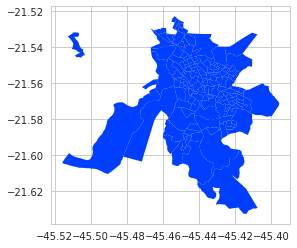

In [12]:
varginha.plot();

### Tarefa: escolher uma das variáveis (V001, $\dots$) e realizar a AEDE (análise exploratória de dados espaciais)

- plotar mapa temático com intervalos iguais  
- plotar mapa temático com intervalos baseados em quantis (melhorar a posição da legenda se necessário)  
- obter boxplot da variável  
- obter $I$ de Moran para a variável e avaliar significância  
- obter diagrama de dispersão de Moran para a variável (com nomes nos eixos)  
- obter mapa LISA
- plotar os bairros correspondentes a *clusters* ou *outliers*

V178: Domicílios particulares permanentes do tipo apartamento próprios e quitados

V180: Domicílios particulares permanentes do tipo apartamento alugados

In [13]:
# aqui substituir por outra variável
v = 'V178'

In [14]:
varginha[v] = varginha[v].astype('int64')

In [15]:
# resumo estatístico
varginha[v].describe()

count    161.000000
mean       5.403727
std       16.201998
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max      131.000000
Name: V178, dtype: float64

In [16]:
# obter a matriz w de pesos espaciais
# lembrar de salvar um shapefile (.shp) apenas com as informações dos setores de Varginha
varginha.to_file('dados/vga_setores.shp')    # salvar o shapefile dos setores
w = ps.queen_from_shapefile('dados/vga_setores.shp') # calcular a matriz de vizinhança

/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))


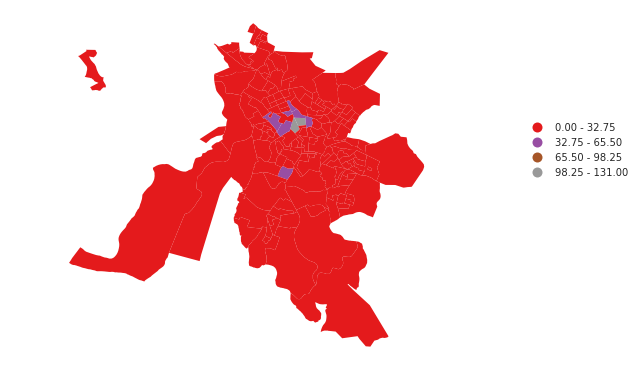

In [17]:
# mapa temático
ax = varginha.plot(column=v, scheme='equal_interval', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

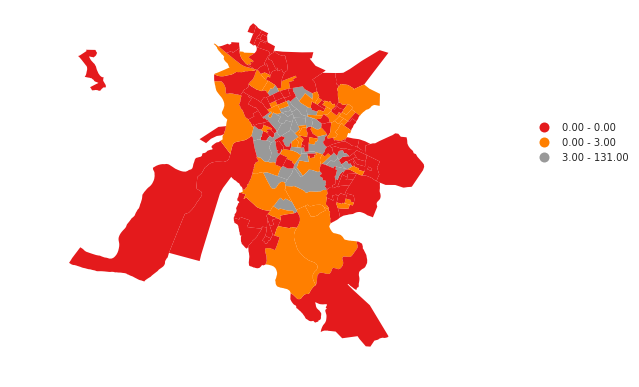

In [18]:
# mapa temático - quantis
ax = varginha.plot(column=v, scheme='quantiles', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

/home/patricia/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


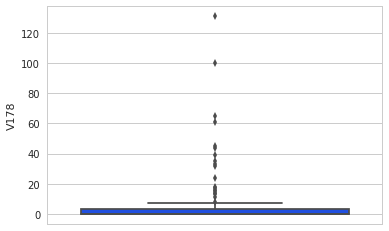

In [19]:
# usar algum gráfico descritivo que represente os mesmos valores e dê ideia da dispersão
sns.boxplot(v, data=varginha, orient='v');

In [20]:
IM = ps.Moran(varginha[v], w)  # variável no dataframe e matriz de vizinhança 
nupis.moran_resumo(IM)         # função do nupis que retorna uma saída organizada do I de Moran

('WARNING: ', 135, ' is an island (no neighbors)')
Moran Rate Summary Report
I        0.458   observed value of Moran’s I
EI_sim   -0.005   average value of I from permutations  
p_sim     0.001   p-value based on permutations


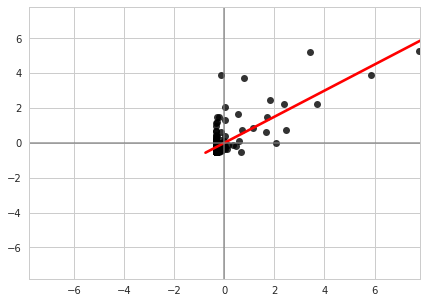

In [21]:
nupis.moran_dispersao(IM)   # diagrama de dispersão de Moran que recebe o objeto criado antes

### Mapas LISA

/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


('WARNING: ', 135, ' is an island (no neighbors)')


/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


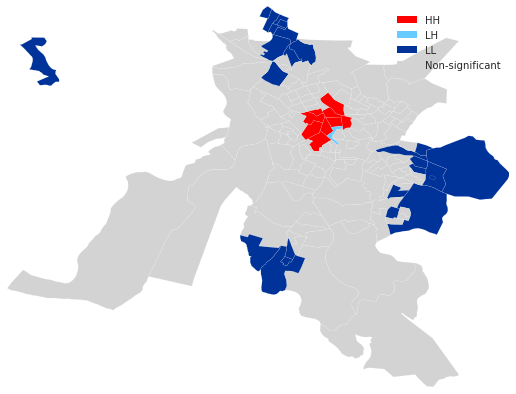

In [22]:
nupis.lisa_mapa(varginha[v], 'dados/vga_setores.shp', p_thres=0.05)   # função do nupis para obter o mapa LISA

In [23]:
shapefile = 'dados/vga_setores.shp'
w = ps.queen_from_shapefile(shapefile)
lisa = ps.Moran_Local(varginha[v], w)
p_thres = 0.05

('WARNING: ', 135, ' is an island (no neighbors)')


/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

In [24]:
lisa.p_sim  # pseudovalores do LISA
sig = lisa.p_sim < 0.05  # identificar significativos
lisa.p_sim[sig]
posicoes = np.where(sig)
varginha['quad'] = lisa.q
mun_sig = varginha.loc[posicoes[0], ['NM_BAIRRO', 'quad']]
# ou ssm.loc[posicoes[0], ['nome_mun', 'quad']].query('quad == 4')
setores_escolhidos = varginha.iloc[mun_sig.index, :]

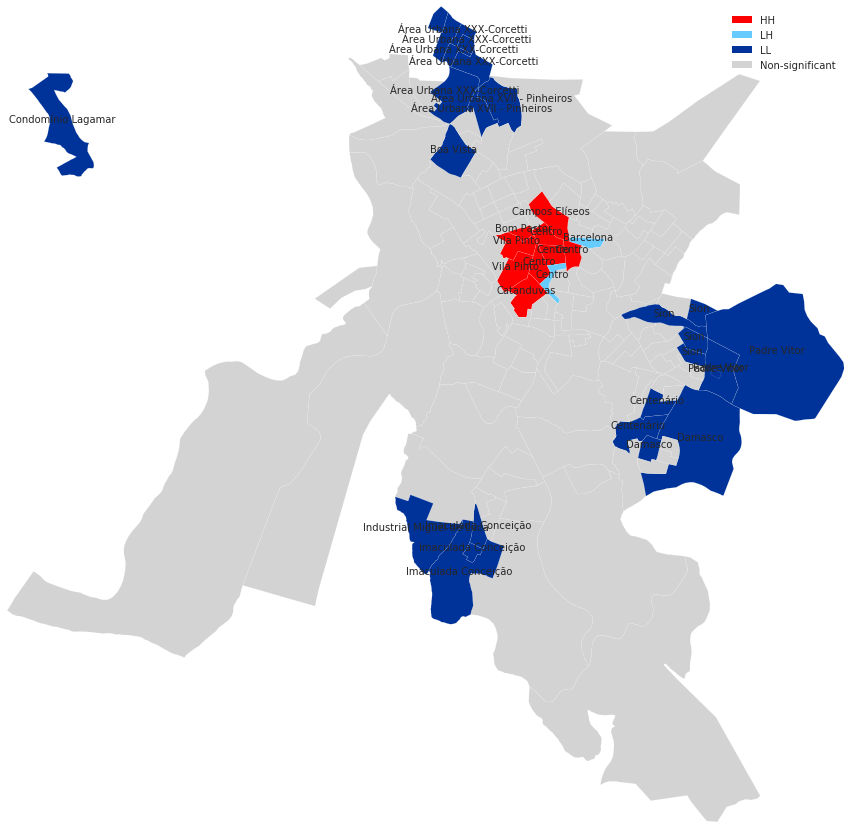

In [25]:
# plotar os nomes dos clusters e outliers espaciais 
fig = plt.figure(figsize=(15, 15))
shp = ps.open(shapefile)
base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, lisa, p_thres=p_thres)
base.set_edgecolor('1')
base.set_linewidth(0.1)
ax = maps.setup_ax([base], [shp.bbox])

boxes, labels = maps.lisa_legend_components(lisa, p_thres=p_thres)
plt.legend(boxes, labels, fancybox=True)

for i in setores_escolhidos.index:

    plt.text(setores_escolhidos.geometry.centroid[i].coords[0][0], setores_escolhidos.geometry.centroid[i].coords[0][1], 
             setores_escolhidos.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')

## A mesma análise para Varginha, porém calculando a porcentagem de apartamentos quitados

- V178: Domicílios particulares permanentes do tipo apartamento próprios e quitados
- V005: Domicílios particulares permanentes do tipo apartamento

In [26]:
# estado de Minas Gerais dividido em setores censitários
setores = gp.read_file('dados/31SEE250GC_SIR.shp') 
# a partir do shapefile de setores de MG, selecionar o município de Varginha e apenas os setores urbanos
vga = setores.query('NM_MUNICIP == "VARGINHA"')
mapa_vga = vga.query('TIPO == "URBANO"')
# transformar a variável CD_GEOCODI, que contém o código do setor, em inteiro
# e mudar o nome para 'Cod_setor' para coincidir com o dataframe mg
mapa_vga.CD_GEOCODI = mapa_vga.CD_GEOCODI.astype('int64')
mapa_vga.rename(columns={'CD_GEOCODI':'Cod_setor'}, inplace=True)

In [27]:
# carregar arquivo maior com dados sobre os setores censitários de MG
mg = pd.read_csv('dados/Domicilio01_MG.csv', encoding='latin1', sep=';', decimal=',')
# pegar apenas as variáveis a serem utilizadas
mg = mg[['Cod_setor', 'Situacao_setor', 'V001', 'V005', 'V178']]

In [28]:
varginha = pd.merge(mapa_vga, mg, on='Cod_setor')
varginha.head()

,ID,Cod_setor,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,Situacao_setor,V001,V005,V178
0,32172,317070105000061,URBANO,317070105013,Campos Elíseos,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.443848235025 -21.5427043990458, ...",1,167,8,2
1,32173,317070105000062,URBANO,317070105013,Campos Elíseos,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.4401641702629 -21.5449895069107,...",1,241,12,4
2,32174,317070105000063,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,POLYGON ((-45.43509370345419 -21.5540721399388...,1,203,9,2
3,32175,317070105000064,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.43508155916039 -21.551410437184,...",1,301,13,8
4,32176,317070105000065,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.4335915918114 -21.5495972632056,...",1,270,0,0


In [29]:
# tranformar as variáveis em inteiro
varginha.V178 = varginha.V178.astype('int64')
varginha.V005 = varginha.V005.astype('int64')

In [30]:
# nova variável: V178N, que calcula a porcentagem de apartamentos próprios e quitados
v = 'V178N'
varginha[v] = (varginha['V178'] / varginha['V005']) * 100
varginha[v] = varginha[v].astype('float64')

In [31]:
# resumo estatístico
varginha[v].describe()

count    100.000000
mean      34.239823
std       28.710058
min        0.000000
25%        3.960561
50%       33.333333
75%       50.000000
max      100.000000
Name: V178N, dtype: float64

In [32]:
# há algumas divisões por 0 pois há setores que não têm nenhum apartamento (V005)
# substituir os valores nan por 0
varginha[v].values[np.isnan(varginha[v].values)] = 0

In [33]:
# resumo estatístico
varginha[v].describe()

count    161.000000
mean      21.266971
std       28.064802
min        0.000000
25%        0.000000
50%        0.000000
75%       42.857143
max      100.000000
Name: V178N, dtype: float64

In [34]:
# obter a matriz w de pesos espaciais
# lembrar de salvar um shapefile (.shp) apenas com as informações dos setores de Varginha
varginha.to_file('dados/vga_setores.shp')    # salvar o shapefile dos setores
w = ps.queen_from_shapefile('dados/vga_setores.shp') # calcular a matriz de vizinhança

/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))


In [35]:
varginha[v]

0       25.000000
1       33.333333
2       22.222222
3       61.538462
4        0.000000
5        0.000000
6       50.000000
7        0.000000
8       50.000000
9       66.666667
10       0.000000
11      14.285714
12       0.000000
13      52.631579
14      53.909465
15      55.454545
16      36.263736
17      20.000000
18      80.000000
19       0.000000
20       0.000000
21       8.333333
22       0.000000
23       0.000000
24       0.000000
25       0.000000
26       0.000000
27       0.000000
28      18.181818
29      50.000000
          ...    
131      0.000000
132      0.000000
133      0.000000
134     25.000000
135      0.000000
136      0.000000
137    100.000000
138      0.000000
139     40.000000
140     50.000000
141      0.000000
142      0.000000
143      2.205882
144      0.000000
145      0.000000
146     46.666667
147      0.000000
148    100.000000
149    100.000000
150      0.000000
151     37.500000
152      7.142857
153      0.000000
154      4.545455
155      0

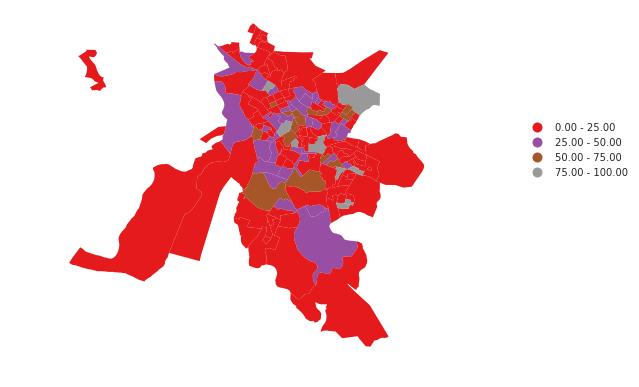

In [36]:
# mapa temático
ax = varginha.plot(column=v, scheme='equal_interval', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

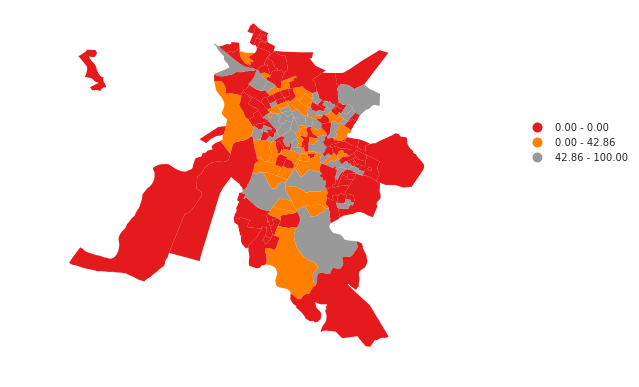

In [37]:
# mapa temático em quantis
ax = varginha.plot(column=v, scheme='quantiles', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

/home/patricia/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


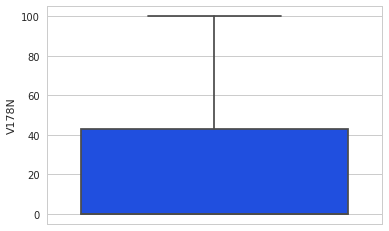

In [38]:
# usar algum gráfico descritivo que represente os mesmos valores e dê ideia da dispersão
sns.boxplot(v, data=varginha, orient='v');

In [39]:
IM = ps.Moran(varginha[v], w)  # variável no dataframe e matriz de vizinhança 
nupis.moran_resumo(IM)         # função do nupis que retorna uma saída organizada do I de Moran

('WARNING: ', 135, ' is an island (no neighbors)')
Moran Rate Summary Report
I        0.108   observed value of Moran’s I
EI_sim   -0.008   average value of I from permutations  
p_sim     0.015   p-value based on permutations


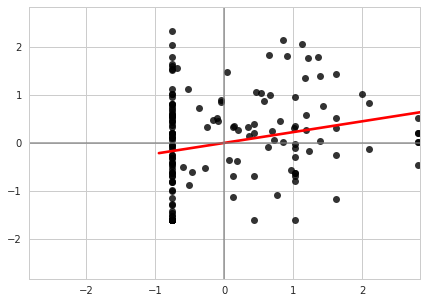

In [40]:
nupis.moran_dispersao(IM)   # diagrama de dispersão de Moran que recebe o objeto criado antes

### Mapas LISA

('WARNING: ', 135, ' is an island (no neighbors)')


/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

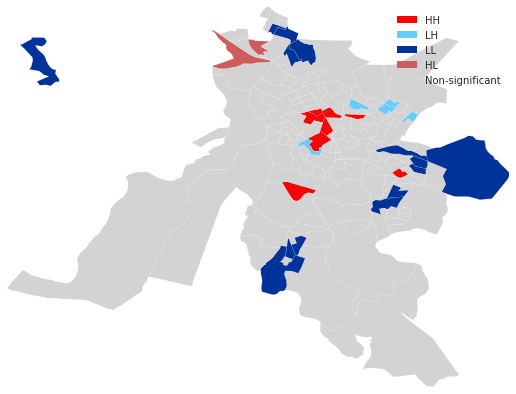

In [41]:
nupis.lisa_mapa(varginha[v], 'dados/vga_setores.shp', p_thres=0.05)   # função do nupis para obter o mapa LISA

In [42]:
shapefile = 'dados/vga_setores.shp'
w = ps.queen_from_shapefile(shapefile)
lisa = ps.Moran_Local(varginha[v], w)
p_thres = 0.05

('WARNING: ', 135, ' is an island (no neighbors)')


/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

In [43]:
lisa.p_sim  # pseudovalores do LISA
sig = lisa.p_sim < 0.05  # identificar significativos
lisa.p_sim[sig]
posicoes = np.where(sig)
varginha['quad'] = lisa.q
mun_sig = varginha.loc[posicoes[0], ['NM_BAIRRO', 'quad']]
# ou ssm.loc[posicoes[0], ['nome_mun', 'quad']].query('quad == 4')
setores_escolhidos = varginha.iloc[mun_sig.index, :]

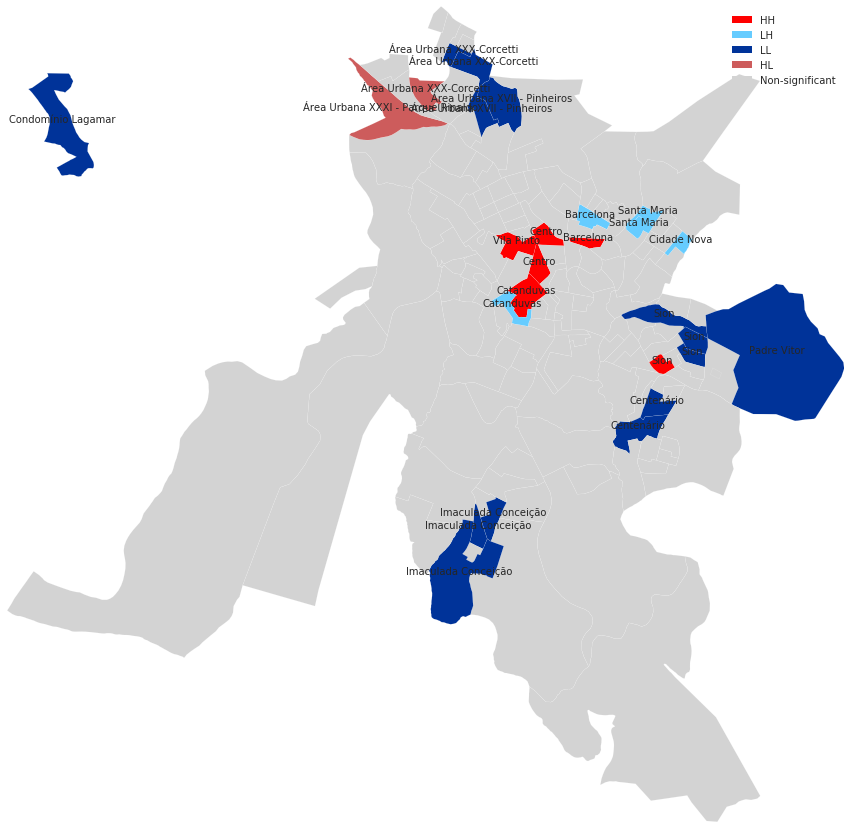

In [44]:
# plotar os nomes dos clusters e outliers espaciais 
fig = plt.figure(figsize=(15, 15))
shp = ps.open(shapefile)
base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, lisa, p_thres=p_thres)
base.set_edgecolor('1')
base.set_linewidth(0.1)
ax = maps.setup_ax([base], [shp.bbox])

boxes, labels = maps.lisa_legend_components(lisa, p_thres=p_thres)
plt.legend(boxes, labels, fancybox=True)

for i in setores_escolhidos.index:

    plt.text(setores_escolhidos.geometry.centroid[i].coords[0][0], setores_escolhidos.geometry.centroid[i].coords[0][1], 
             setores_escolhidos.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')

## A mesma análise para Varginha, porém calculando a porcentagem de apartamentos (V005 / V002)

- V005: Domicílios particulares permanentes do tipo apartamento
- V002: Domicílios particulares permanentes

In [45]:
# estado de Minas Gerais dividido em setores censitários
setores = gp.read_file('dados/31SEE250GC_SIR.shp') 
# a partir do shapefile de setores de MG, selecionar o município de Varginha e apenas os setores urbanos
vga = setores.query('NM_MUNICIP == "VARGINHA"')
mapa_vga = vga.query('TIPO == "URBANO"')
# transformar a variável CD_GEOCODI, que contém o código do setor, em inteiro
# e mudar o nome para 'Cod_setor' para coincidir com o dataframe mg
mapa_vga.CD_GEOCODI = mapa_vga.CD_GEOCODI.astype('int64')
mapa_vga.rename(columns={'CD_GEOCODI':'Cod_setor'}, inplace=True)

In [46]:
# carregar arquivo maior com dados sobre os setores censitários de MG
mg = pd.read_csv('dados/Domicilio01_MG.csv', encoding='latin1', sep=';', decimal=',')
# pegar apenas as variáveis a serem utilizadas
mg = mg[['Cod_setor', 'Situacao_setor', 'V002', 'V005']]

In [47]:
varginha = pd.merge(mapa_vga, mg, on='Cod_setor')
varginha.head()

,ID,Cod_setor,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,Situacao_setor,V002,V005
0,32172,317070105000061,URBANO,317070105013,Campos Elíseos,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.443848235025 -21.5427043990458, ...",1,167,8
1,32173,317070105000062,URBANO,317070105013,Campos Elíseos,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.4401641702629 -21.5449895069107,...",1,241,12
2,32174,317070105000063,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,POLYGON ((-45.43509370345419 -21.5540721399388...,1,203,9
3,32175,317070105000064,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.43508155916039 -21.551410437184,...",1,301,13
4,32176,317070105000065,URBANO,317070105014,Barcelona,31707010500,,317070105,VARGINHA,3170701,VARGINHA,VARGINHA,SUL/SUDOESTE DE MINAS,"POLYGON ((-45.4335915918114 -21.5495972632056,...",1,270,0


In [48]:
# tranformar as variáveis em inteiro
varginha.V005 = varginha.V005.astype('int64')
varginha.V002 = varginha.V002.astype('int64')

In [49]:
# nova variável: V1, que calcula a porcentagem de apartamentos
v = 'V1'
varginha[v] = (varginha['V005'] / varginha['V002']) * 100
varginha[v] = varginha[v].astype('float64')

In [50]:
# resumo estatístico
varginha[v].describe()

count    159.000000
mean       5.969602
std       13.509398
min        0.000000
25%        0.000000
50%        0.840336
75%        4.362112
max       84.083045
Name: V1, dtype: float64

In [51]:
# há algumas divisões por 0 pois há setores que não têm nenhum apartamento (V005)
# substituir os valores nan por 0
varginha[v].values[np.isnan(varginha[v].values)] = 0

In [52]:
# resumo estatístico
varginha[v].describe()

count    161.000000
mean       5.895445
std       13.441073
min        0.000000
25%        0.000000
50%        0.816327
75%        4.318937
max       84.083045
Name: V1, dtype: float64

In [53]:
# obter a matriz w de pesos espaciais
# lembrar de salvar um shapefile (.shp) apenas com as informações dos setores de Varginha
varginha.to_file('dados/vga_setores.shp')    # salvar o shapefile dos setores
w = ps.queen_from_shapefile('dados/vga_setores.shp') # calcular a matriz de vizinhança

/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))


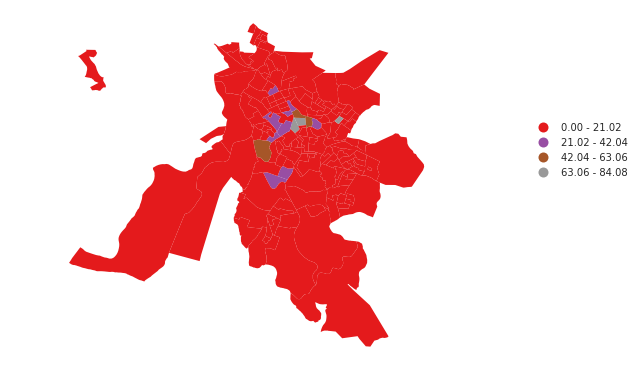

In [54]:
# mapa temático
ax = varginha.plot(column=v, scheme='equal_interval', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

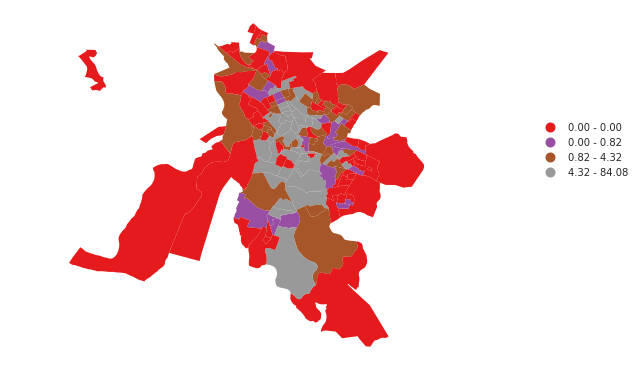

In [55]:
# mapa temático em quantis
ax = varginha.plot(column=v, scheme='quantiles', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

/home/patricia/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


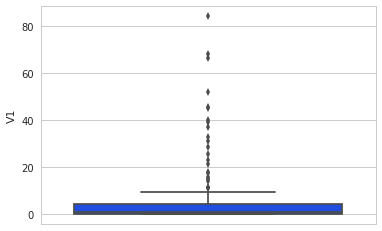

In [56]:
# usar algum gráfico descritivo que represente os mesmos valores e dê ideia da dispersão
sns.boxplot(v, data=varginha, orient='v');

In [57]:
IM = ps.Moran(varginha[v], w)  # variável no dataframe e matriz de vizinhança 
nupis.moran_resumo(IM)         # função do nupis que retorna uma saída organizada do I de Moran

('WARNING: ', 135, ' is an island (no neighbors)')
Moran Rate Summary Report
I        0.399   observed value of Moran’s I
EI_sim   -0.006   average value of I from permutations  
p_sim     0.001   p-value based on permutations


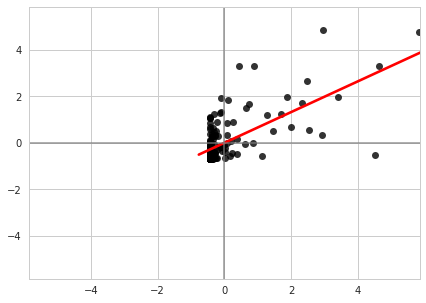

In [58]:
nupis.moran_dispersao(IM)   # diagrama de dispersão de Moran que recebe o objeto criado antes

### Mapas LISA

('WARNING: ', 135, ' is an island (no neighbors)')


/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

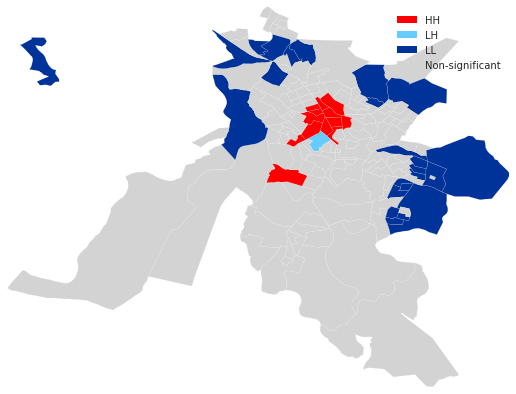

In [59]:
nupis.lisa_mapa(varginha[v], 'dados/vga_setores.shp', p_thres=0.05)   # função do nupis para obter o mapa LISA

In [60]:
shapefile = 'dados/vga_setores.shp'
w = ps.queen_from_shapefile(shapefile)
lisa = ps.Moran_Local(varginha[v], w)
p_thres = 0.05

('WARNING: ', 135, ' is an island (no neighbors)')


/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

In [61]:
lisa.p_sim  # pseudovalores do LISA
sig = lisa.p_sim < 0.05  # identificar significativos
lisa.p_sim[sig]
posicoes = np.where(sig)
varginha['quad'] = lisa.q
mun_sig = varginha.loc[posicoes[0], ['NM_BAIRRO', 'quad']]
# ou ssm.loc[posicoes[0], ['nome_mun', 'quad']].query('quad == 4')
setores_escolhidos = varginha.iloc[mun_sig.index, :]

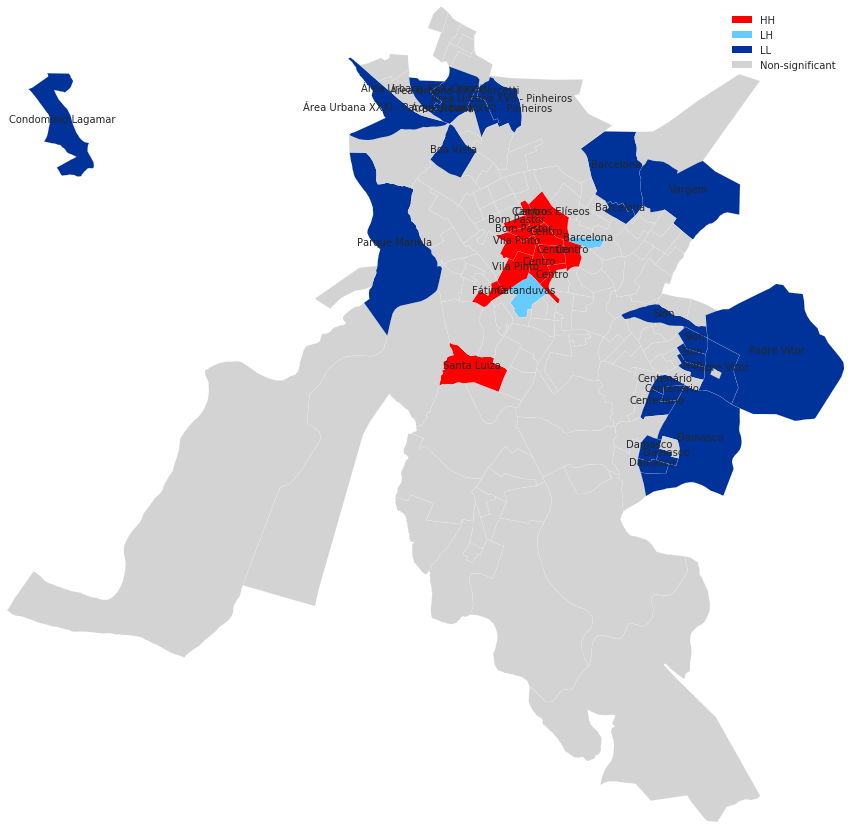

In [62]:
# plotar os nomes dos clusters e outliers espaciais 
fig = plt.figure(figsize=(15, 15))
shp = ps.open(shapefile)
base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, lisa, p_thres=p_thres)
base.set_edgecolor('1')
base.set_linewidth(0.1)
ax = maps.setup_ax([base], [shp.bbox])

boxes, labels = maps.lisa_legend_components(lisa, p_thres=p_thres)
plt.legend(boxes, labels, fancybox=True)

for i in setores_escolhidos.index:

    plt.text(setores_escolhidos.geometry.centroid[i].coords[0][0], setores_escolhidos.geometry.centroid[i].coords[0][1], 
             setores_escolhidos.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# AEDE do número de apartamentos quitados para os municípios de MG

Ao realizar a análise espacial do estado de MG, se considerarmos todos os setores censitários, essa análise pode ficar pesada e muito demorada. Por isso, acho melhor considerar municípios ($n=853$) e não setores ($n = 32564$). Porém, as informações que estão no arquivo 'Domicilio01_MG' só estão divididas por setor censitário. Por isso, tive que primeiro agrupar as informações por município para só depois realizar a análise. Acompanhem as células abaixo para entender o que eu fiz.

In [47]:
%matplotlib inline
import pandas as pd
import nupis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gp
import pysal as ps
import pysal.contrib.viz.mapping as maps
import palettable

pd.options.mode.chained_assignment = None

sns.set(style='whitegrid', palette='bright', context='notebook')

Unir as informações presentes da variável V178 com o shapefile dividido por municípios de MG.

In [48]:
# carregar arquivo maior com dados sobre os setores censitários de MG (urbanos e rurais)
mg = pd.read_csv('dados/Domicilio01_MG.csv', encoding='latin1', sep=';', decimal=',')
# pegar apenas as variáveis a serem utilizadas
mg = mg[['Cod_setor', 'Situacao_setor', 'V178']]

In [49]:
# carregar shapefile do estado de Minas Gerais dividido em setores censitários
# essas informações só estão disponíveis por setor censitário e não por município
mapa_mg = gp.read_file('dados/31SEE250GC_SIR.shp') 
# transformar a variável CD_GEOCODI, que contém o código do setor, em inteiro
# e renomeá-la como 'Cod_setor' para coincidir com o dataframe 'mg'
mapa_mg.CD_GEOCODI = mapa_mg.CD_GEOCODI.astype('int64')
mapa_mg.rename(columns={'CD_GEOCODI':'Cod_setor'}, inplace=True)

O problema é que algumas observações apresentam, no lugar do valor da variável escolhida, o valor 'X' para proteger a identidade de moradores (provavelmente se o setor censitário for muito pequeno). Vamos substituir esses valores 'X' pela média dos valores das observações.

In [50]:
# V178
# calcular a média das observações (sem contar os valores 'X', claro)
media = int(round(mg.drop(mg.query('V178 == "X"').index).V178.astype(float).mean(), 0))
# substituir os valores 'X' pela média
mg['V178'] = mg['V178'].replace('X', media)
# transformar a variável em inteira (é uma contagem)
mg['V178'] = mg['V178'].astype('int64')

In [51]:
v = 'V178'

In [52]:
mg[v].describe()

count    32564.000000
mean         9.122221
std         27.447893
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max        385.000000
Name: V178, dtype: float64

In [53]:
# unir as informações geográficas de MG com as informações do csv (objeto 'mg')
# os dados ainda estão divididos em setores censitários de MG
mapa_mg = pd.merge(mapa_mg, mg, on='Cod_setor')
mapa_mg.shape

(32564, 16)

O objeto 'mapa_mg' contém os valores da variável escolhida em setores censitários. Como queremos as informações divididas por município, primeiro precisamos carregar o *shapefile* com as informações dos municípios.

In [54]:
# malha de MG dividida em municípios
mun_mg = gp.read_file('dados/31MUE250GC_SIR.shp')

In [55]:
# transformar a variável CD_GEOCMU, que contém o código do município, em inteiro
# e criar nova coluna chamada 'Cod_mun'
mun_mg.CD_GEOCMU = mun_mg.CD_GEOCMU.astype('int64')
mun_mg.rename(columns={'CD_GEOCMU':'Cod_mun'}, inplace=True)

# transformar a variável CD_GEOCODM, que contém o código do município no objeto mapa_mg, em inteiro
# e criar nova coluna chamada 'Cod_mun'
mapa_mg.CD_GEOCODM = mapa_mg.CD_GEOCODM.astype('int64')
mapa_mg.rename(columns={'CD_GEOCODM':'Cod_mun'}, inplace=True)

Neste momento, as informações contidas em 'Domicilio01_MG' (por setor censitário) serão agrupadas por município.

In [64]:
# novo dataframe com os valores da variável escolhida agrupada por município
# verificar se faz mais sentido a média ou a soma
# neste caso, como estamos interessados no número absoluto de apartamentos quitados,
# faria sentido a soma dos apartamentos quitados por setor ou a média
# escolhi a média
df = pd.DataFrame(mapa_mg.groupby('Cod_mun')[v].mean()).reset_index()

In [65]:
# novo dataframe com as informações da variável por município
var_mun = pd.merge(mun_mg, df, on='Cod_mun')

In [66]:
var_mun.head()

,NM_MUNICIP,Cod_mun,geometry,V178
0,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.429672447 -18.16543081755956, -4...",1.153846
1,ABAETÉ,3100203,POLYGON ((-45.13929899999993 -19.2104779965868...,1.736842
2,ABRE CAMPO,3100302,"POLYGON ((-42.310709 -20.14278899661063, -42.3...",3.130435
3,ACAIACA,3100401,POLYGON ((-43.02386900000001 -20.4102179966172...,0.250000
4,AÇUCENA,3100500,POLYGON ((-42.36208300000006 -18.9256939975794...,0.600000


In [67]:
var_mun.V178.describe()

count    853.000000
mean       1.786064
std        3.519406
min        0.000000
25%        0.100000
50%        0.558140
75%        2.000000
max       38.809091
Name: V178, dtype: float64

In [68]:
var_mun.to_file('dados/minas_setores.shp')    # salvar o shapefile com as informações dos municípios
w = ps.queen_from_shapefile('dados/minas_setores.shp') # calcular a matriz de vizinhança

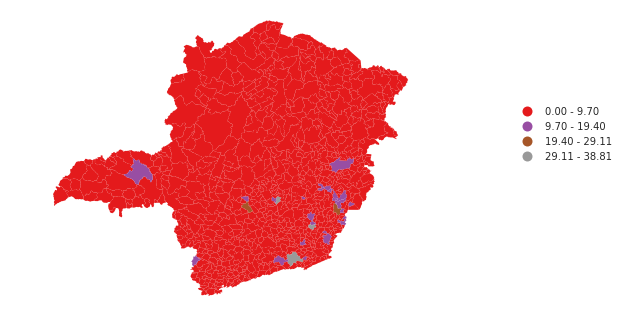

In [69]:
# mapa temático
ax = var_mun.plot(column=v, scheme='equal_interval', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

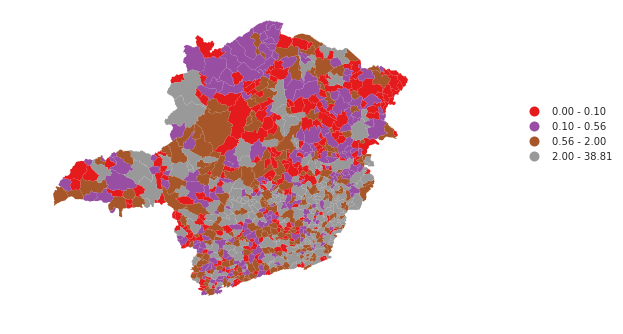

In [70]:
# mapa temático
ax = var_mun.plot(column=v, scheme='quantiles', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

/home/patricia/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


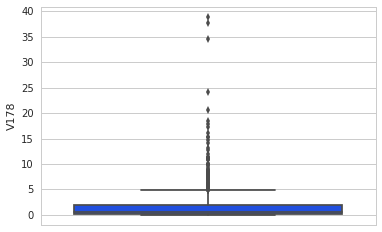

In [71]:
# usar algum gráfico descritivo que represente os mesmos valores e dê ideia da dispersão
sns.boxplot(v, data=var_mun, orient='v');

In [72]:
IM = ps.Moran(var_mun[v], w)  # variável no dataframe e matriz de vizinhança 
nupis.moran_resumo(IM)         # função do nupis que retorna uma saída organizada do I de Moran

Moran Rate Summary Report
I        0.265   observed value of Moran’s I
EI_sim   -0.001   average value of I from permutations  
p_sim     0.001   p-value based on permutations


In [73]:
shapefile = 'dados/minas_setores.shp'
w = ps.queen_from_shapefile(shapefile)
lisa = ps.Moran_Local(var_mun[v], w)
p_thres = 0.05

In [74]:
lisa.p_sim  # pseudovalores do LISA
sig = lisa.p_sim < 0.05  # identificar significativos
lisa.p_sim[sig]
posicoes = np.where(sig)
var_mun['quad'] = lisa.q
mun_sig = var_mun.loc[posicoes[0], ['NM_MUNICIP', 'quad']]
cidades_escolhidas = var_mun.iloc[mun_sig.index, :]

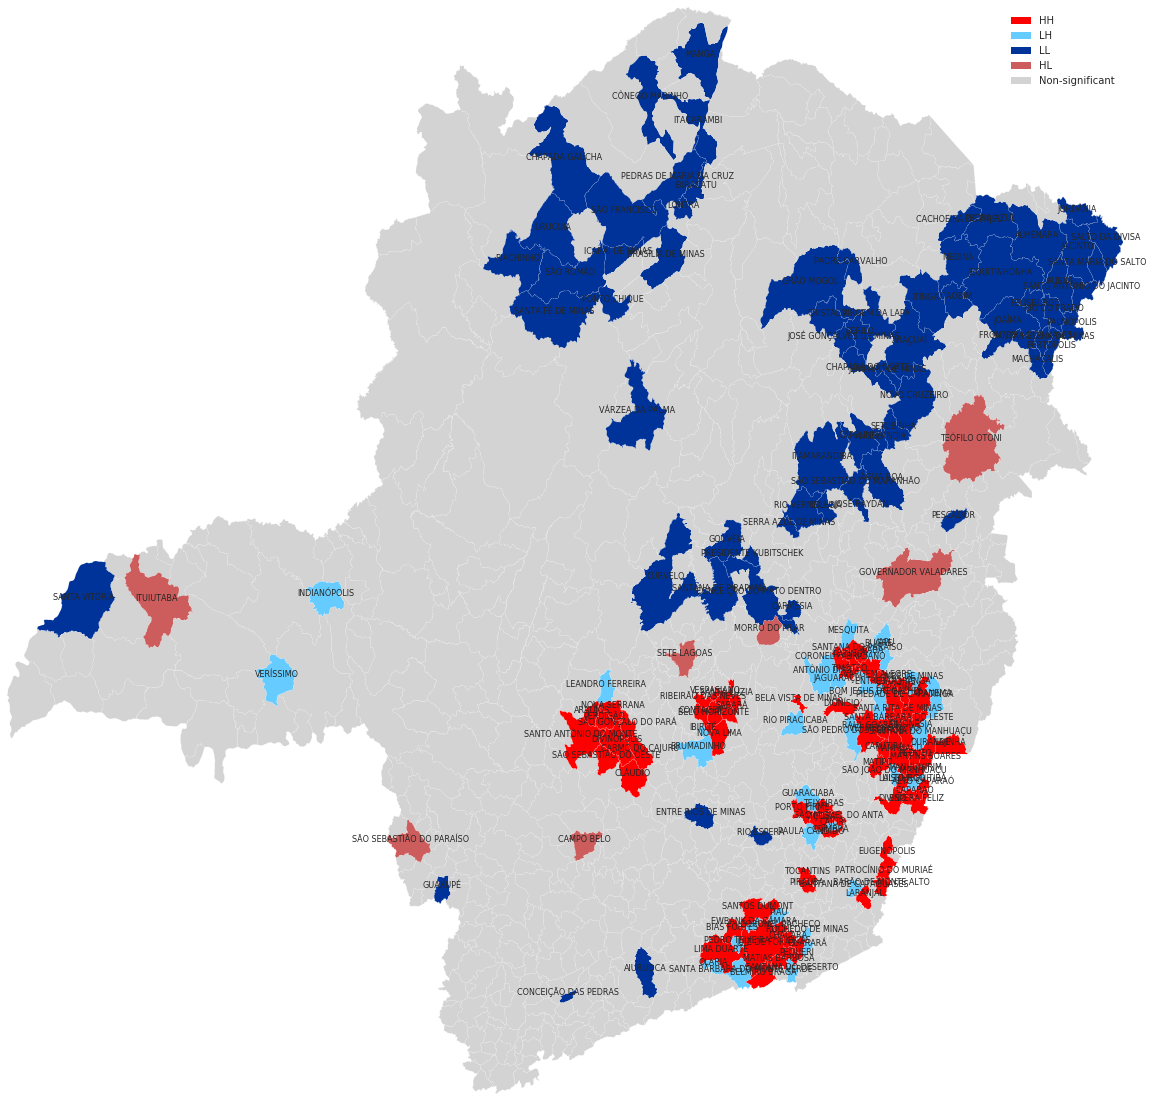

In [75]:
# plotar os nomes dos clusters e outliers espaciais 
fig = plt.figure(figsize=(20, 20))
shp = ps.open(shapefile)
base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, lisa, p_thres=p_thres)
base.set_edgecolor('1')
base.set_linewidth(0.1)
ax = maps.setup_ax([base], [shp.bbox])

boxes, labels = maps.lisa_legend_components(lisa, p_thres=p_thres)
plt.legend(boxes, labels, fancybox=True)

for i in cidades_escolhidas.index:

    plt.text(cidades_escolhidas.geometry.centroid[i].coords[0][0], cidades_escolhidas.geometry.centroid[i].coords[0][1], 
             cidades_escolhidas.NM_MUNICIP[i],
             fontsize=8, horizontalalignment='center', verticalalignment='bottom')

# AEDE da porcentagem de apartamentos quitados para os municípios de MG

In [2]:
%matplotlib inline
import pandas as pd
import nupis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gp
import pysal as ps
import pysal.contrib.viz.mapping as maps
import palettable

pd.options.mode.chained_assignment = None

sns.set(style='whitegrid', palette='bright', context='notebook')

In [3]:
# carregar arquivo maior com dados sobre os setores censitários de MG (urbanos e rurais)
mg = pd.read_csv('dados/Domicilio01_MG.csv', encoding='latin1', sep=';', decimal=',')
# pegar apenas as variáveis a serem utilizadas
mg = mg[['Cod_setor', 'Situacao_setor', 'V001', 'V005', 'V178']]

In [4]:
# carregar shapefile do estado de Minas Gerais dividido em setores censitários
# essas informações só estão disponíveis por setor censitário e não por município
mapa_mg = gp.read_file('dados/31SEE250GC_SIR.shp') 
# transformar a variável CD_GEOCODI, que contém o código do setor, em inteiro
# e renomeá-la como 'Cod_setor' para coincidir com o dataframe 'mg'
mapa_mg.CD_GEOCODI = mapa_mg.CD_GEOCODI.astype('int64')
mapa_mg.rename(columns={'CD_GEOCODI':'Cod_setor'}, inplace=True)

In [5]:
# V178
# calcular a média das observações (sem contar os valores 'X', claro)
media = int(round(mg.drop(mg.query('V178 == "X"').index).V178.astype(float).mean(), 0))
# substituir os valores 'X' pela média
mg['V178'] = mg['V178'].replace('X', media)
# transformar a variável em inteira (é uma contagem)
mg['V178'] = mg['V178'].astype('int64')

In [6]:
# V005
# calcular a média das observações (sem contar os valores 'X', claro)
media = int(round(mg.drop(mg.query('V005 == "X"').index).V005.astype(float).mean(), 0))
# substituir os valores 'X' pela média
mg['V005'] = mg['V005'].replace('X', media)
# transformar a variável em inteira (é uma contagem)
mg['V005'] = mg['V005'].astype('int64')

Nova variável: divisão entre o número de apartamentos quitados e o número total de apartamentos.

In [7]:
mg['V178N'] = (mg['V178'] / mg['V005']) * 100

In [8]:
v = 'V178N'

In [9]:
mg[v].describe()

count    15204.000000
mean        45.993423
std         29.725068
min          0.000000
25%         25.000000
50%         48.275862
75%         64.571030
max        100.000000
Name: V178N, dtype: float64

In [10]:
# há algumas divisões por 0 
# substituir os valores nan por 0
mg[v].values[np.isnan(mg[v].values)] = 0

In [11]:
# unir as informações geográficas de MG com as informações do csv (objeto 'mg')
# os dados ainda estão divididos em setores censitários de MG
mapa_mg = pd.merge(mapa_mg, mg, on='Cod_setor')
mapa_mg.shape

(32564, 19)

O objeto 'mapa_mg' contém os valores da variável escolhida em setores censitários. Como queremos as informações divididas por município, primeiro precisamos carregar o *shapefile* com as informações dos municípios.

In [12]:
# malha de MG dividida em municípios
mun_mg = gp.read_file('dados/31MUE250GC_SIR.shp')

In [13]:
# transformar a variável CD_GEOCMU, que contém o código do município, em inteiro
# e criar nova coluna chamada 'Cod_mun'
mun_mg.CD_GEOCMU = mun_mg.CD_GEOCMU.astype('int64')
mun_mg.rename(columns={'CD_GEOCMU':'Cod_mun'}, inplace=True)

# transformar a variável CD_GEOCODM, que contém o código do município no objeto mapa_mg, em inteiro
# e criar nova coluna chamada 'Cod_mun'
mapa_mg.CD_GEOCODM = mapa_mg.CD_GEOCODM.astype('int64')
mapa_mg.rename(columns={'CD_GEOCODM':'Cod_mun'}, inplace=True)

Neste momento, as informações contidas em 'Domicilio01_MG' (por setor censitário) serão agrupadas por município.

In [14]:
# novo dataframe com os valores da variável escolhida agrupada por município
# verificar se faz mais sentido a média ou a soma
# neste caso, como estamos interessados na porcentagem de apartamentos quitados
df = pd.DataFrame(mapa_mg.groupby('Cod_mun')[v].mean()).reset_index()

In [15]:
# novo dataframe com as informações da variável por município
var_mun = pd.merge(mun_mg, df, on='Cod_mun')

In [16]:
var_mun.head()

,NM_MUNICIP,Cod_mun,geometry,V178N
0,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.429672447 -18.16543081755956, -4...",25.567766
1,ABAETÉ,3100203,POLYGON ((-45.13929899999993 -19.2104779965868...,17.542153
2,ABRE CAMPO,3100302,"POLYGON ((-42.310709 -20.14278899661063, -42.3...",11.543328
3,ACAIACA,3100401,POLYGON ((-43.02386900000001 -20.4102179966172...,6.250000
4,AÇUCENA,3100500,POLYGON ((-42.36208300000006 -18.9256939975794...,7.708333


In [17]:
var_mun.to_file('dados/minas_setores.shp')    # salvar o shapefile com as informações dos municípios
w = ps.queen_from_shapefile('dados/minas_setores.shp') # calcular a matriz de vizinhança

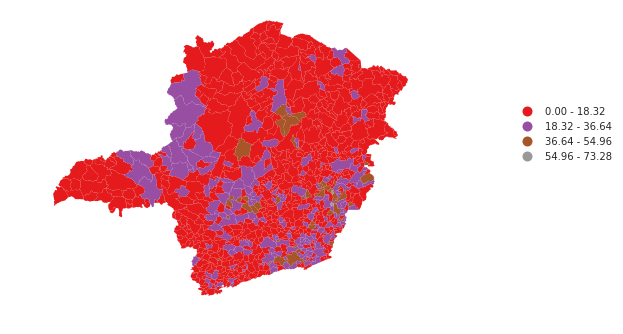

In [18]:
# mapa temático
ax = var_mun.plot(column=v, scheme='equal_interval', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

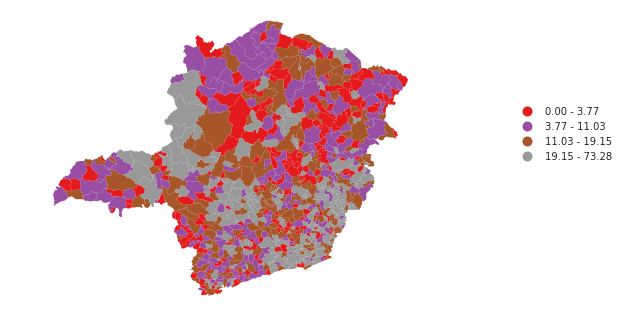

In [19]:
# mapa temático
ax = var_mun.plot(column=v, scheme='quantiles', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

/home/patricia/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


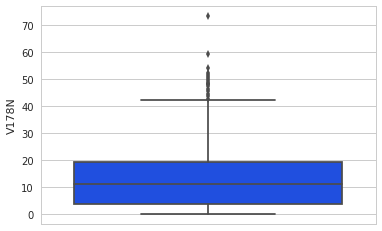

In [20]:
# usar algum gráfico descritivo que represente os mesmos valores e dê ideia da dispersão
sns.boxplot(v, data=var_mun, orient='v');

In [21]:
IM = ps.Moran(var_mun[v], w)  # variável no dataframe e matriz de vizinhança 
nupis.moran_resumo(IM)         # função do nupis que retorna uma saída organizada do I de Moran

Moran Rate Summary Report
I        0.299   observed value of Moran’s I
EI_sim   -0.001   average value of I from permutations  
p_sim     0.001   p-value based on permutations


In [22]:
shapefile = 'dados/minas_setores.shp'
w = ps.queen_from_shapefile(shapefile)
lisa = ps.Moran_Local(var_mun[v], w)
p_thres = 0.05

In [23]:
lisa.p_sim  # pseudovalores do LISA
sig = lisa.p_sim < 0.05  # identificar significativos
lisa.p_sim[sig]
posicoes = np.where(sig)
var_mun['quad'] = lisa.q
mun_sig = var_mun.loc[posicoes[0], ['NM_MUNICIP', 'quad']]
cidades_escolhidas = var_mun.iloc[mun_sig.index, :]

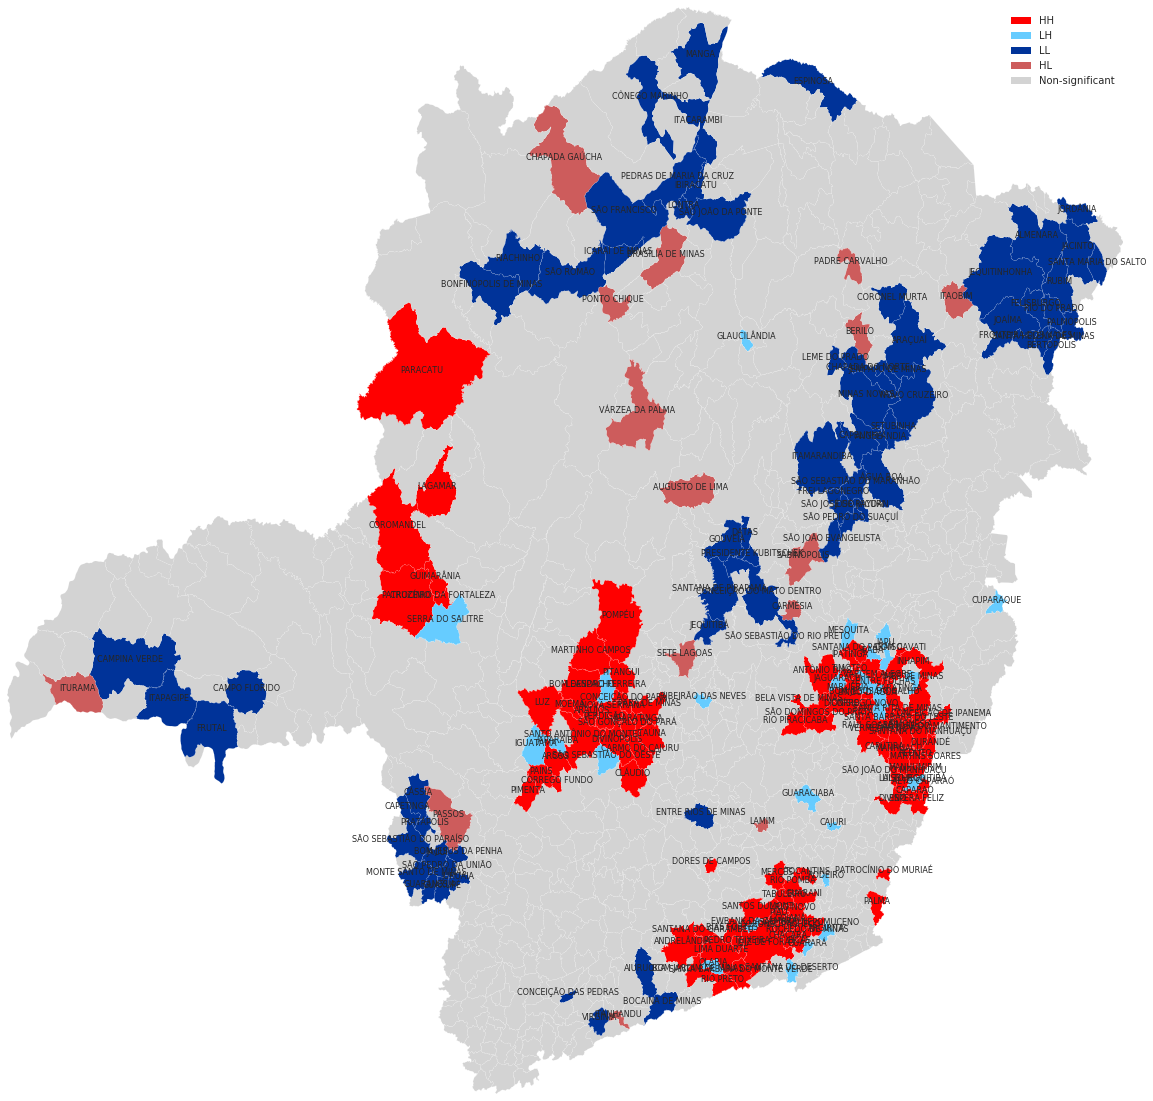

In [24]:
# plotar os nomes dos clusters e outliers espaciais 
fig = plt.figure(figsize=(20, 20))
shp = ps.open(shapefile)
base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, lisa, p_thres=p_thres)
base.set_edgecolor('1')
base.set_linewidth(0.1)
ax = maps.setup_ax([base], [shp.bbox])

boxes, labels = maps.lisa_legend_components(lisa, p_thres=p_thres)
plt.legend(boxes, labels, fancybox=True)

for i in cidades_escolhidas.index:

    plt.text(cidades_escolhidas.geometry.centroid[i].coords[0][0], cidades_escolhidas.geometry.centroid[i].coords[0][1], 
             cidades_escolhidas.NM_MUNICIP[i],
             fontsize=8, horizontalalignment='center', verticalalignment='bottom')

# AEDE da porcentagem de apartamentos para os municípios de MG

In [31]:
%matplotlib inline
import pandas as pd
import nupis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gp
import pysal as ps
import pysal.contrib.viz.mapping as maps
import palettable

pd.options.mode.chained_assignment = None

sns.set(style='whitegrid', palette='bright', context='notebook')

Unir as informações presentes da variável V178 com o shapefile dividido por municípios de MG.

In [32]:
# carregar arquivo maior com dados sobre os setores censitários de MG (urbanos e rurais)
mg = pd.read_csv('dados/Domicilio01_MG.csv', encoding='latin1', sep=';', decimal=',')
# pegar apenas as variáveis a serem utilizadas
mg = mg[['Cod_setor', 'Situacao_setor', 'V002', 'V005']]

In [33]:
# carregar shapefile do estado de Minas Gerais dividido em setores censitários
mapa_mg = gp.read_file('dados/31SEE250GC_SIR.shp') 
# transformar a variável CD_GEOCODI, que contém o código do setor, em inteiro
# e renomeá-la como 'Cod_setor' para coincidir com o dataframe 'mg'
mapa_mg.CD_GEOCODI = mapa_mg.CD_GEOCODI.astype('int64')
mapa_mg.rename(columns={'CD_GEOCODI':'Cod_setor'}, inplace=True)

O problema é que algumas observações apresentam, no lugar do valor da variável escolhida, o valor 'X' para proteger a identidade de moradores (provavelmente se o setor censitário for muito pequeno). Vamos substituir esses valores 'X' por 0. Aqui não se pode substituir pela média para não correr o risco de que o número de apartamentos de um setor seja maior do que o número total de domicílios do setor (que inclui o número de apartamentos).

In [34]:
# V002
v = 'V002'
# substituir os valores 'X' por 0
mg[v] = mg[v].replace('X', 0)
# transformar a variável em inteira (é uma contagem)
mg[v] = mg[v].astype('int64')

In [35]:
# V005
v = 'V005'
# substituir os valores 'X' por 0
mg[v] = mg[v].replace('X', 0)
# transformar a variável em inteira (é uma contagem)
mg[v] = mg[v].astype('int64')

In [36]:
# nova variável 'V01': porcentagem de apartamentos
mg['V01'] = (mg['V005'] / mg['V002']) * 100

In [37]:
v = 'V01'

In [93]:
# há algumas divisões por 0 
# substituir os valores nan por 0
# mg[v].values[np.isnan(mg[v].values)] = 0

# há algumas divisões por 0 
# substituir os valores Inf por 0
# mg[v].values[np.isinf(mg[v].values)] = 0

In [38]:
# unir as informações geográficas de MG com as informações do csv (objeto 'mg')
# os dados ainda estão divididos em setores censitários de MG
mapa_mg = pd.merge(mapa_mg, mg, on='Cod_setor')
mapa_mg.shape

(32564, 18)

In [39]:
mapa_mg.columns

Index(['ID', 'Cod_setor', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'geometry', 'Situacao_setor', 'V002', 'V005',
       'V01'],
      dtype='object')

O objeto 'mapa_mg' contém os valores da variável escolhida em setores censitários.

In [40]:
# malha de MG dividida em municípios
mun_mg = gp.read_file('dados/31MUE250GC_SIR.shp')

In [41]:
# transformar a variável CD_GEOCMU, que contém o código do município, em inteiro
# e criar nova coluna chamada 'Cod_mun'
mun_mg.CD_GEOCMU = mun_mg.CD_GEOCMU.astype('int64')
mun_mg.rename(columns={'CD_GEOCMU':'Cod_mun'}, inplace=True)

# transformar a variável CD_GEOCODM, que contém o código do município no objeto mapa_mg, em inteiro
# e criar nova coluna chamada 'Cod_mun'
mapa_mg.CD_GEOCODM = mapa_mg.CD_GEOCODM.astype('int64')
mapa_mg.rename(columns={'CD_GEOCODM':'Cod_mun'}, inplace=True)

In [42]:
# novo dataframe com os valores da variável escolhida agrupada por município
# verificar se faz mais sentido a média ou a soma
df = pd.DataFrame(mapa_mg.groupby('Cod_mun')[v].mean()).reset_index()

In [43]:
# novo dataframe com as informações da variável por município
var_mun = pd.merge(mun_mg, df, on='Cod_mun')

In [44]:
var_mun[v].describe()

count    853.000000
mean       1.750110
std        3.368326
min        0.000000
25%        0.105042
50%        0.520566
75%        1.859270
max       36.099904
Name: V01, dtype: float64

In [45]:
var_mun.to_file('dados/minas_setores.shp')    # salvar o shapefile com as informações dos municípios
w = ps.queen_from_shapefile('dados/minas_setores.shp') # calcular a matriz de vizinhança

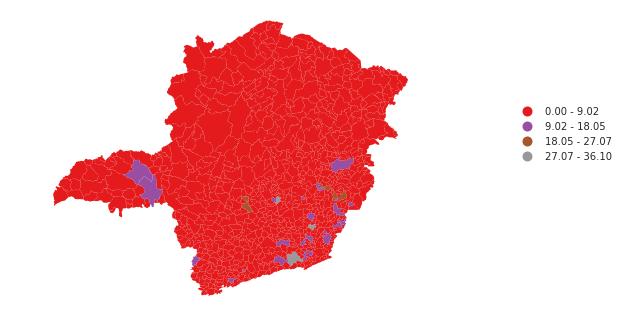

In [46]:
# mapa temático
ax = var_mun.plot(column=v, scheme='equal_interval', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

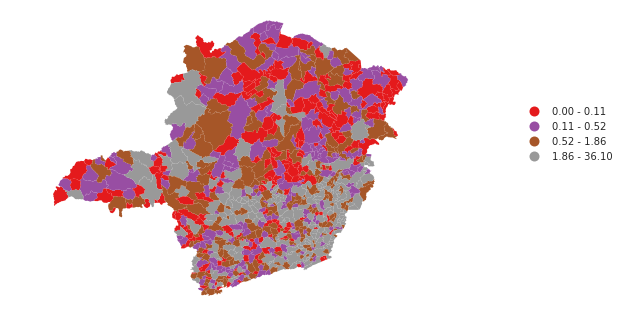

In [47]:
# mapa temático
ax = var_mun.plot(column=v, scheme='quantiles', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

/home/patricia/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


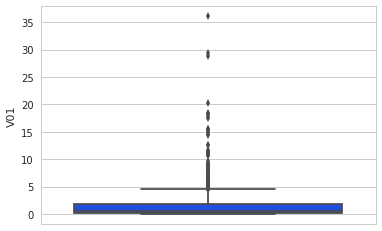

In [48]:
# usar algum gráfico descritivo que represente os mesmos valores e dê ideia da dispersão
sns.boxplot(v, data=var_mun, orient='v');

In [49]:
IM = ps.Moran(var_mun[v], w)  # variável no dataframe e matriz de vizinhança 
nupis.moran_resumo(IM)         # função do nupis que retorna uma saída organizada do I de Moran

Moran Rate Summary Report
I        0.244   observed value of Moran’s I
EI_sim   -0.001   average value of I from permutations  
p_sim     0.001   p-value based on permutations


In [50]:
shapefile = 'dados/minas_setores.shp'
w = ps.queen_from_shapefile(shapefile)
lisa = ps.Moran_Local(var_mun[v], w)
p_thres = 0.05

In [51]:
lisa.p_sim  # pseudovalores do LISA
sig = lisa.p_sim < 0.05  # identificar significativos
lisa.p_sim[sig]
posicoes = np.where(sig)
var_mun['quad'] = lisa.q
mun_sig = var_mun.loc[posicoes[0], ['NM_MUNICIP', 'quad']]
cidades_escolhidas = var_mun.iloc[mun_sig.index, :]

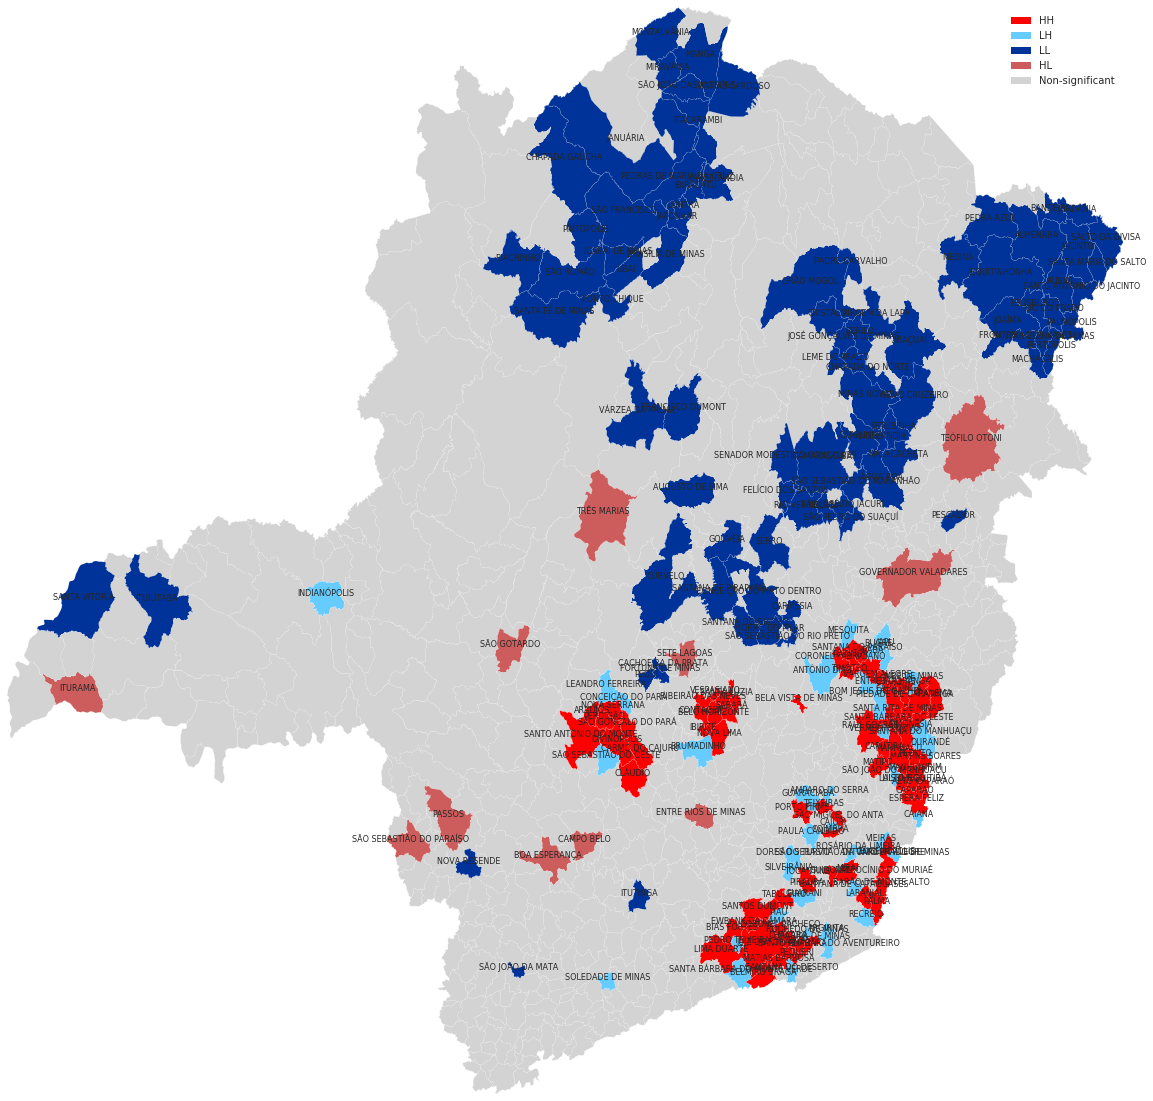

In [52]:
# plotar os nomes dos clusters e outliers espaciais 
fig = plt.figure(figsize=(20, 20))
shp = ps.open(shapefile)
base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, lisa, p_thres=p_thres)
base.set_edgecolor('1')
base.set_linewidth(0.1)
ax = maps.setup_ax([base], [shp.bbox])

boxes, labels = maps.lisa_legend_components(lisa, p_thres=p_thres)
plt.legend(boxes, labels, fancybox=True)

for i in cidades_escolhidas.index:

    plt.text(cidades_escolhidas.geometry.centroid[i].coords[0][0], cidades_escolhidas.geometry.centroid[i].coords[0][1], 
             cidades_escolhidas.NM_MUNICIP[i],
             fontsize=8, horizontalalignment='center', verticalalignment='bottom')